# Data Preprocessing Pipeline

This notebook preprocesses the raw NOAA ISD data for use in the GNN weather forecasting model.

## Objectives
1. Load raw data from parquet file
2. Temporal alignment - handle missing timestamps, create regular hourly grid
3. Quality control - outlier detection, remove bad readings
4. Feature engineering - temporal features, wind components, normalization
5. Station network analysis - compute distances, analyze coverage
6. Train/validation/test split
7. Save preprocessed data

## Input
- `data/raw/noaa_isd_raw_data.parquet` - Raw hourly observations
- `data/raw/noaa_isd_station_metadata.csv` - Station coordinates and metadata

## Output
- `data/processed/noaa_isd_preprocessed.parquet` - Cleaned, feature-engineered data
- `data/processed/station_metadata.csv` - Filtered station metadata
- `data/processed/preprocessing_stats.json` - Normalization parameters

In [1]:
# Imports
import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import json
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Setup project path
current_dir = Path(os.getcwd()).resolve()
if current_dir.name == '02_data_preprocessing':
    project_root = current_dir.parent.parent
elif current_dir.name == 'notebooks':
    project_root = current_dir.parent
else:
    for parent in current_dir.parents:
        if (parent / 'src').exists() and (parent / 'notebooks').exists():
            project_root = parent
            break
    else:
        project_root = current_dir

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src.utils.config import RAW_DATA_DIR, PROCESSED_DATA_DIR

print(f"Project root: {project_root}")
print(f"Raw data directory: {RAW_DATA_DIR}")
print(f"Processed data directory: {PROCESSED_DATA_DIR}")

# Create directories
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)

Project root: C:\Users\Kata\Desktop\earth-sgnn
Raw data directory: C:\Users\Kata\Desktop\earth-sgnn\data\raw
Processed data directory: C:\Users\Kata\Desktop\earth-sgnn\data\processed


## 1. Load Raw Data

In [2]:
# Load raw data
print("Loading raw data...")
raw_data_file = RAW_DATA_DIR / "noaa_isd_raw_data.parquet"
metadata_file = RAW_DATA_DIR / "noaa_isd_station_metadata.csv"

if not raw_data_file.exists():
    raise FileNotFoundError(f"Raw data file not found: {raw_data_file}")

df = pd.read_parquet(raw_data_file)
station_meta = pd.read_csv(metadata_file)

print(f"\nRaw data shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nStations: {df['station_id'].nunique()}")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1e6:.1f} MB")

Loading raw data...

Raw data shape: (9612898, 12)
Columns: ['station_id', 'timestamp', 'latitude', 'longitude', 'elevation', 'name', 'temperature_2m', 'dewpoint_2m', 'wind_direction_10m', 'wind_speed_10m', 'surface_pressure', 'relative_humidity_2m']

Stations: 1090
Date range: 2022-01-01 00:00:00 to 2022-12-31 23:59:00

Memory usage: 1072.3 MB


In [3]:
# Preview data
print("Sample data:")
display(df.head(10))

print("\nData types:")
print(df.dtypes)

print("\nStation metadata sample:")
display(station_meta.head(10))

Sample data:


,station_id,timestamp,latitude,longitude,elevation,name,temperature_2m,dewpoint_2m,wind_direction_10m,wind_speed_10m,surface_pressure,relative_humidity_2m
0,1001099999,2022-01-01 01:00:00,70.933333,-8.666667,9.0,"JAN MAYEN NOR NAVY, NO",-8.7,-11.1,358.0,13.9,1014.0,82.758801
1,1001099999,2022-01-01 02:00:00,70.933333,-8.666667,9.0,"JAN MAYEN NOR NAVY, NO",-9.0,-11.4,353.0,12.7,1014.1,82.718506
2,1001099999,2022-01-01 05:00:00,70.933333,-8.666667,9.0,"JAN MAYEN NOR NAVY, NO",-9.9,-12.7,350.0,10.5,1013.8,79.975301
3,1001099999,2022-01-01 07:00:00,70.933333,-8.666667,9.0,"JAN MAYEN NOR NAVY, NO",-10.5,-14.1,351.0,8.5,1013.4,74.841808
4,1001099999,2022-01-01 08:00:00,70.933333,-8.666667,9.0,"JAN MAYEN NOR NAVY, NO",-10.5,-15.8,349.0,7.9,1013.2,65.062245
5,1001099999,2022-01-01 09:00:00,70.933333,-8.666667,9.0,"JAN MAYEN NOR NAVY, NO",-10.7,-17.3,2.0,6.8,1013.2,58.317554
6,1001099999,2022-01-01 10:00:00,70.933333,-8.666667,9.0,"JAN MAYEN NOR NAVY, NO",-11.7,-15.8,343.0,8.9,1013.4,71.589050
7,1001099999,2022-01-01 11:00:00,70.933333,-8.666667,9.0,"JAN MAYEN NOR NAVY, NO",-11.5,-16.2,344.0,6.0,1013.3,68.148376
8,1001099999,2022-01-01 12:00:00,70.933333,-8.666667,9.0,"JAN MAYEN NOR NAVY, NO",-12.4,-17.6,340.0,8.2,1012.5,65.143940
9,1001099999,2022-01-01 13:00:00,70.933333,-8.666667,9.0,"JAN MAYEN NOR NAVY, NO",-12.5,-19.3,340.0,7.4,1011.9,56.839831



Data types:
station_id                       int64
timestamp               datetime64[us]
latitude                       float64
longitude                      float64
elevation                      float64
name                               str
temperature_2m                 float64
dewpoint_2m                    float64
wind_direction_10m             float64
wind_speed_10m                 float64
surface_pressure               float64
relative_humidity_2m           float64
dtype: object

Station metadata sample:


,station_id,name,latitude,longitude,elevation,n_observations,start_date,end_date
0,1001099999,"JAN MAYEN NOR NAVY, NO",70.933333,-8.666667,9.00,4022,2022-01-01 01:00:00,2022-12-31 23:00:00
1,1001499999,"SORSTOKKEN, NO",59.791925,5.340850,48.76,6216,2022-01-02 11:20:00,2022-12-30 18:20:00
2,1002099999,"VERLEGENHUKEN, NO",80.050000,16.250000,8.00,99,2022-01-08 21:00:00,2022-12-31 20:00:00
3,1003099999,"HORNSUND, NO",77.000000,15.500000,12.00,237,2022-01-02 06:00:00,2022-12-31 06:00:00
4,1006099999,"EDGEOYA, NO",78.250000,22.816667,14.00,123,2022-01-01 17:00:00,2022-12-29 21:00:00
5,1007099999,"NY ALESUND, SV",78.916667,11.933333,7.70,977,2022-01-01 12:00:00,2022-12-31 21:00:00
6,1008099999,"LONGYEAR, SV",78.246111,15.465556,26.82,18125,2022-01-01 00:20:00,2022-12-31 23:50:00
7,1009099999,"KARL XII OYA, SV",80.650000,25.000000,5.00,133,2022-01-03 21:00:00,2022-12-31 00:00:00
8,1010099999,"ANDOYA, NO",69.292500,16.144167,13.10,19535,2022-01-01 00:20:00,2022-12-31 23:50:00
9,1011099999,"KVITOYA, SV",80.066667,31.500000,10.00,80,2022-01-03 22:00:00,2022-12-31 23:00:00


## 2. Initial Data Quality Assessment

Missing Value Analysis
                      Missing Count  Missing %  Valid Count
temperature_2m               224581       2.34      9388317
dewpoint_2m                  321354       3.34      9291544
relative_humidity_2m         323901       3.37      9288997
wind_speed_10m               582649       6.06      9030249
wind_direction_10m          1073161      11.16      8539737
surface_pressure            5371707      55.88      4241191


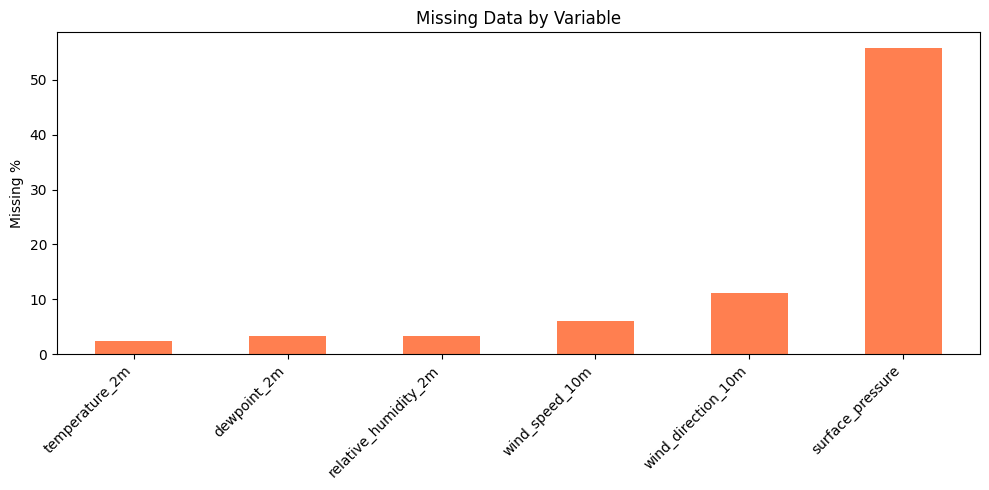

In [4]:
# Check missing values
print("=" * 60)
print("Missing Value Analysis")
print("=" * 60)

# Define target variables (meteorological data)
target_vars = ['temperature_2m', 'dewpoint_2m', 'relative_humidity_2m', 
               'wind_speed_10m', 'wind_direction_10m', 'surface_pressure']

missing_counts = df[target_vars].isnull().sum()
missing_pct = (missing_counts / len(df) * 100).round(2)

missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing %': missing_pct,
    'Valid Count': len(df) - missing_counts
})
print(missing_df)

# Visualize missing data
fig, ax = plt.subplots(figsize=(10, 5))
missing_pct.plot(kind='bar', ax=ax, color='coral')
ax.set_ylabel('Missing %')
ax.set_title('Missing Data by Variable')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [5]:
# Basic statistics for each variable
print("\n" + "=" * 60)
print("Variable Statistics")
print("=" * 60)

stats = df[target_vars].describe()
print(stats.round(2))


Variable Statistics
       temperature_2m  dewpoint_2m  relative_humidity_2m  wind_speed_10m  \
count      9388317.00   9291544.00            9288997.00      9030249.00   
mean             7.16         3.54                 79.62            4.84   
std              8.50         8.01                 15.66            3.69   
min            -59.90       -95.00                  0.00            0.00   
25%              2.00        -1.00                 70.48            2.10   
50%              8.00         4.80                 82.50            4.00   
75%             13.00         9.30                 92.74            6.40   
max             47.00        26.00                100.00           49.40   

       wind_direction_10m  surface_pressure  
count          8539737.00        4241191.00  
mean               199.38           1012.52  
std                 92.70             12.55  
min                  1.00            902.10  
25%                130.00           1005.30  
50%               


Station Coverage Analysis

Observations per station:
  Min: 1
  Max: 40458
  Mean: 8819
  Median: 8211

Temporal coverage (% of year):
  Min: 0.0%
  Max: 461.8%
  Mean: 100.7%


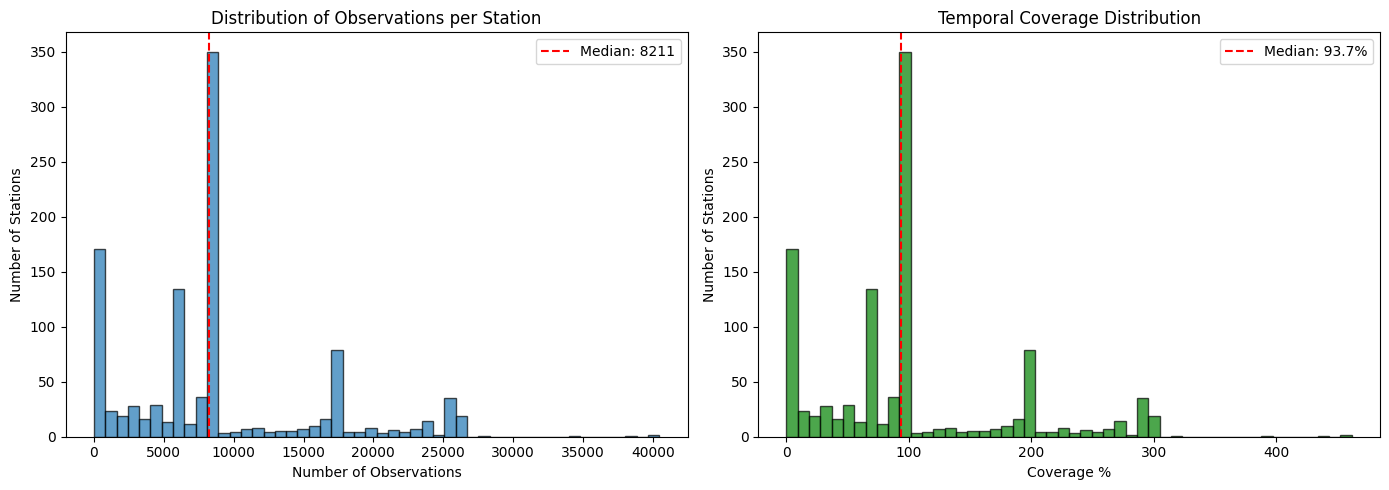

In [6]:
# Observations per station distribution
print("\n" + "=" * 60)
print("Station Coverage Analysis")
print("=" * 60)

station_counts = df.groupby('station_id').size()
print(f"\nObservations per station:")
print(f"  Min: {station_counts.min()}")
print(f"  Max: {station_counts.max()}")
print(f"  Mean: {station_counts.mean():.0f}")
print(f"  Median: {station_counts.median():.0f}")

# Expected hourly observations for 1 year = 8760
expected_hours = 8760
coverage_pct = (station_counts / expected_hours * 100)
print(f"\nTemporal coverage (% of year):")
print(f"  Min: {coverage_pct.min():.1f}%")
print(f"  Max: {coverage_pct.max():.1f}%")
print(f"  Mean: {coverage_pct.mean():.1f}%")

# Plot distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(station_counts, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of Observations')
axes[0].set_ylabel('Number of Stations')
axes[0].set_title('Distribution of Observations per Station')
axes[0].axvline(station_counts.median(), color='r', linestyle='--', label=f'Median: {station_counts.median():.0f}')
axes[0].legend()

axes[1].hist(coverage_pct, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('Coverage %')
axes[1].set_ylabel('Number of Stations')
axes[1].set_title('Temporal Coverage Distribution')
axes[1].axvline(coverage_pct.median(), color='r', linestyle='--', label=f'Median: {coverage_pct.median():.1f}%')
axes[1].legend()

plt.tight_layout()
plt.show()

## 3. Filter Stations by Quality Criteria

In [7]:
# Define quality thresholds
MIN_COVERAGE_PCT = 50  # Stations must have at least 50% temporal coverage
MIN_OBSERVATIONS = int(expected_hours * MIN_COVERAGE_PCT / 100)

print(f"Quality filter: Stations must have at least {MIN_COVERAGE_PCT}% coverage ({MIN_OBSERVATIONS} observations)")

# Find qualifying stations
qualifying_stations = station_counts[station_counts >= MIN_OBSERVATIONS].index.tolist()
print(f"\nStations meeting criteria: {len(qualifying_stations)} / {len(station_counts)} ({100*len(qualifying_stations)/len(station_counts):.1f}%)")

# Filter data
df_filtered = df[df['station_id'].isin(qualifying_stations)].copy()
print(f"\nFiltered data shape: {df_filtered.shape}")
print(f"Retained observations: {len(df_filtered):,} / {len(df):,} ({100*len(df_filtered)/len(df):.1f}%)")

Quality filter: Stations must have at least 50% coverage (4380 observations)

Stations meeting criteria: 822 / 1090 (75.4%)

Filtered data shape: (9326949, 12)
Retained observations: 9,326,949 / 9,612,898 (97.0%)


In [8]:
# Update station metadata to only include qualifying stations
station_meta_filtered = station_meta[station_meta['station_id'].isin(qualifying_stations)].copy()
print(f"Filtered stations: {len(station_meta_filtered)}")

# Quick geographic check
print(f"\nGeographic range:")
print(f"  Latitude: {station_meta_filtered['latitude'].min():.2f} to {station_meta_filtered['latitude'].max():.2f}")
print(f"  Longitude: {station_meta_filtered['longitude'].min():.2f} to {station_meta_filtered['longitude'].max():.2f}")
print(f"  Elevation: {station_meta_filtered['elevation'].min():.0f}m to {station_meta_filtered['elevation'].max():.0f}m")

Filtered stations: 822

Geographic range:
  Latitude: 49.21 to 83.65
  Longitude: -73.00 to 31.05
  Elevation: -3m to 1245m


## 4. Outlier Detection and Removal

In [9]:
# Define physically plausible ranges for each variable
VALID_RANGES = {
    'temperature_2m': (-90, 60),      # Celsius (Earth records: -89.2 to 56.7)
    'dewpoint_2m': (-90, 40),          # Celsius
    'relative_humidity_2m': (0, 100),  # Percentage
    'wind_speed_10m': (0, 120),        # m/s (hurricane: ~70 m/s)
    'wind_direction_10m': (0, 360),    # Degrees
    'surface_pressure': (850, 1090)    # hPa (typical range)
}

print("=" * 60)
print("Outlier Detection (Physical Range Check)")
print("=" * 60)

outlier_counts = {}
for var, (vmin, vmax) in VALID_RANGES.items():
    if var in df_filtered.columns:
        outliers = (df_filtered[var] < vmin) | (df_filtered[var] > vmax)
        outlier_counts[var] = outliers.sum()
        print(f"{var}: {outliers.sum()} outliers ({100*outliers.sum()/len(df_filtered):.3f}%)")
        
        # Replace outliers with NaN
        df_filtered.loc[outliers, var] = np.nan

Outlier Detection (Physical Range Check)
temperature_2m: 0 outliers (0.000%)
dewpoint_2m: 1 outliers (0.000%)
relative_humidity_2m: 0 outliers (0.000%)
wind_speed_10m: 0 outliers (0.000%)
wind_direction_10m: 0 outliers (0.000%)
surface_pressure: 0 outliers (0.000%)


In [10]:
# Statistical outlier detection using IQR method (optional, more aggressive)
# Using 3*IQR which is more permissive than 1.5*IQR

print("\n" + "=" * 60)
print("Statistical Outlier Detection (3*IQR)")
print("=" * 60)

IQR_MULTIPLIER = 3.0  # Use 3.0 for less aggressive filtering

for var in target_vars:
    if var in df_filtered.columns and var != 'wind_direction_10m':  # Skip circular variable
        Q1 = df_filtered[var].quantile(0.25)
        Q3 = df_filtered[var].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - IQR_MULTIPLIER * IQR
        upper_bound = Q3 + IQR_MULTIPLIER * IQR
        
        outliers = (df_filtered[var] < lower_bound) | (df_filtered[var] > upper_bound)
        n_outliers = outliers.sum()
        
        if n_outliers > 0:
            print(f"{var}: {n_outliers} outliers outside [{lower_bound:.1f}, {upper_bound:.1f}]")
            df_filtered.loc[outliers, var] = np.nan


Statistical Outlier Detection (3*IQR)
temperature_2m: 3654 outliers outside [-31.0, 46.0]
dewpoint_2m: 7941 outliers outside [-32.2, 40.6]
relative_humidity_2m: 687 outliers outside [3.7, 159.5]
wind_speed_10m: 59195 outliers outside [-10.2, 18.5]
surface_pressure: 553 outliers outside [959.1, 1067.6]


## 5. Feature Engineering

In [11]:
# 5.1 Temporal Features
print("=" * 60)
print("Creating Temporal Features")
print("=" * 60)

# Ensure timestamp is datetime
df_filtered['timestamp'] = pd.to_datetime(df_filtered['timestamp'])

# Extract temporal components
df_filtered['hour'] = df_filtered['timestamp'].dt.hour
df_filtered['day_of_year'] = df_filtered['timestamp'].dt.dayofyear
df_filtered['month'] = df_filtered['timestamp'].dt.month
df_filtered['day_of_week'] = df_filtered['timestamp'].dt.dayofweek

# Cyclical encoding for hour (captures continuity between 23:00 and 00:00)
df_filtered['hour_sin'] = np.sin(2 * np.pi * df_filtered['hour'] / 24)
df_filtered['hour_cos'] = np.cos(2 * np.pi * df_filtered['hour'] / 24)

# Cyclical encoding for day of year (captures seasonality)
df_filtered['doy_sin'] = np.sin(2 * np.pi * df_filtered['day_of_year'] / 365)
df_filtered['doy_cos'] = np.cos(2 * np.pi * df_filtered['day_of_year'] / 365)

print("Added: hour, day_of_year, month, day_of_week")
print("Added: hour_sin, hour_cos, doy_sin, doy_cos (cyclical encodings)")

Creating Temporal Features
Added: hour, day_of_year, month, day_of_week
Added: hour_sin, hour_cos, doy_sin, doy_cos (cyclical encodings)


In [12]:
# 5.2 Wind Component Features
print("\n" + "=" * 60)
print("Creating Wind Component Features")
print("=" * 60)

# Convert wind speed and direction to u,v components
# u = east-west component (positive = from west)
# v = north-south component (positive = from south)
# Note: meteorological convention - direction is where wind comes FROM

wind_dir_rad = np.deg2rad(df_filtered['wind_direction_10m'])
df_filtered['wind_u'] = -df_filtered['wind_speed_10m'] * np.sin(wind_dir_rad)
df_filtered['wind_v'] = -df_filtered['wind_speed_10m'] * np.cos(wind_dir_rad)

print("Added: wind_u (east-west component), wind_v (north-south component)")

# Check the new features
print(f"\nWind u range: {df_filtered['wind_u'].min():.1f} to {df_filtered['wind_u'].max():.1f} m/s")
print(f"Wind v range: {df_filtered['wind_v'].min():.1f} to {df_filtered['wind_v'].max():.1f} m/s")


Creating Wind Component Features
Added: wind_u (east-west component), wind_v (north-south component)

Wind u range: -18.5 to 18.5 m/s
Wind v range: -18.5 to 18.5 m/s


In [13]:
# 5.3 Derived meteorological features
print("\n" + "=" * 60)
print("Creating Derived Meteorological Features")
print("=" * 60)

# Temperature-Dewpoint spread (indicator of relative humidity)
df_filtered['temp_dewpoint_spread'] = df_filtered['temperature_2m'] - df_filtered['dewpoint_2m']

print("Added: temp_dewpoint_spread")
print(f"  Range: {df_filtered['temp_dewpoint_spread'].min():.1f} to {df_filtered['temp_dewpoint_spread'].max():.1f} °C")


Creating Derived Meteorological Features
Added: temp_dewpoint_spread
  Range: 0.0 to 43.8 °C


## 6. Normalize/Standardize Features

In [14]:
# Define features to normalize
FEATURES_TO_NORMALIZE = [
    'temperature_2m', 'dewpoint_2m', 'relative_humidity_2m',
    'wind_speed_10m', 'surface_pressure',
    'wind_u', 'wind_v', 'temp_dewpoint_spread'
]

# Calculate normalization statistics (using training data later, but for now use all data)
normalization_stats = {}

print("=" * 60)
print("Normalization Statistics")
print("=" * 60)

for var in FEATURES_TO_NORMALIZE:
    if var in df_filtered.columns:
        mean_val = df_filtered[var].mean()
        std_val = df_filtered[var].std()
        min_val = df_filtered[var].min()
        max_val = df_filtered[var].max()
        
        normalization_stats[var] = {
            'mean': float(mean_val),
            'std': float(std_val),
            'min': float(min_val),
            'max': float(max_val)
        }
        
        # Create normalized version (z-score)
        df_filtered[f'{var}_normalized'] = (df_filtered[var] - mean_val) / std_val
        
        print(f"{var}: mean={mean_val:.2f}, std={std_val:.2f}")

print(f"\nCreated {len(FEATURES_TO_NORMALIZE)} normalized features")

Normalization Statistics
temperature_2m: mean=7.34, std=8.42
dewpoint_2m: mean=3.71, std=7.85
relative_humidity_2m: mean=79.60, std=15.66
wind_speed_10m: mean=4.70, std=3.37
surface_pressure: mean=1012.74, std=12.38
wind_u: mean=1.04, std=4.10
wind_v: mean=0.87, std=4.08
temp_dewpoint_spread: mean=3.65, std=3.40

Created 8 normalized features


## 7. Station Network Analysis

In [15]:
# Compute pairwise distances between stations
from scipy.spatial.distance import cdist

print("=" * 60)
print("Station Network Analysis")
print("=" * 60)

# Get station coordinates
station_coords = station_meta_filtered[['station_id', 'latitude', 'longitude', 'elevation']].copy()
station_coords = station_coords.set_index('station_id')

# Haversine distance function
def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate the great circle distance between two points in kilometers."""
    R = 6371  # Earth's radius in km
    
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    return R * c

# Compute distance matrix
n_stations = len(station_coords)
print(f"Computing distance matrix for {n_stations} stations...")

coords = station_coords[['latitude', 'longitude']].values
distance_matrix = np.zeros((n_stations, n_stations))

for i in range(n_stations):
    for j in range(i+1, n_stations):
        dist = haversine_distance(
            coords[i, 0], coords[i, 1],
            coords[j, 0], coords[j, 1]
        )
        distance_matrix[i, j] = dist
        distance_matrix[j, i] = dist

print(f"Distance matrix computed: {distance_matrix.shape}")

Station Network Analysis
Computing distance matrix for 822 stations...
Distance matrix computed: (822, 822)



Station distance statistics (km):
  Min: 0.0
  Max: 4243.7
  Mean: 1234.5
  Median: 1083.3

Nearest neighbor distance statistics (km):
  Min: 0.0
  Max: 642.5
  Mean: 35.6
  Median: 29.0


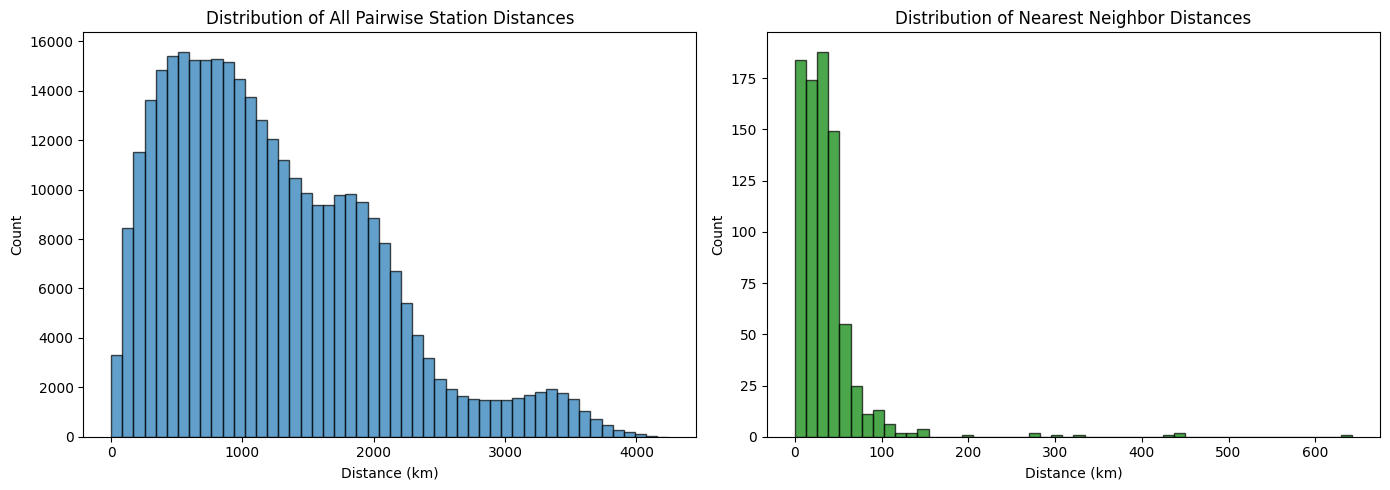

In [16]:
# Analyze station distances
# Get upper triangle (exclude diagonal)
upper_tri = distance_matrix[np.triu_indices(n_stations, k=1)]

print(f"\nStation distance statistics (km):")
print(f"  Min: {upper_tri.min():.1f}")
print(f"  Max: {upper_tri.max():.1f}")
print(f"  Mean: {upper_tri.mean():.1f}")
print(f"  Median: {np.median(upper_tri):.1f}")

# Find nearest neighbor distances
nn_distances = []
for i in range(n_stations):
    distances = distance_matrix[i, :]
    distances = distances[distances > 0]  # Exclude self
    if len(distances) > 0:
        nn_distances.append(distances.min())

nn_distances = np.array(nn_distances)
print(f"\nNearest neighbor distance statistics (km):")
print(f"  Min: {nn_distances.min():.1f}")
print(f"  Max: {nn_distances.max():.1f}")
print(f"  Mean: {nn_distances.mean():.1f}")
print(f"  Median: {np.median(nn_distances):.1f}")

# Plot distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(upper_tri, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Distance (km)')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of All Pairwise Station Distances')

axes[1].hist(nn_distances, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('Distance (km)')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of Nearest Neighbor Distances')

plt.tight_layout()
plt.show()

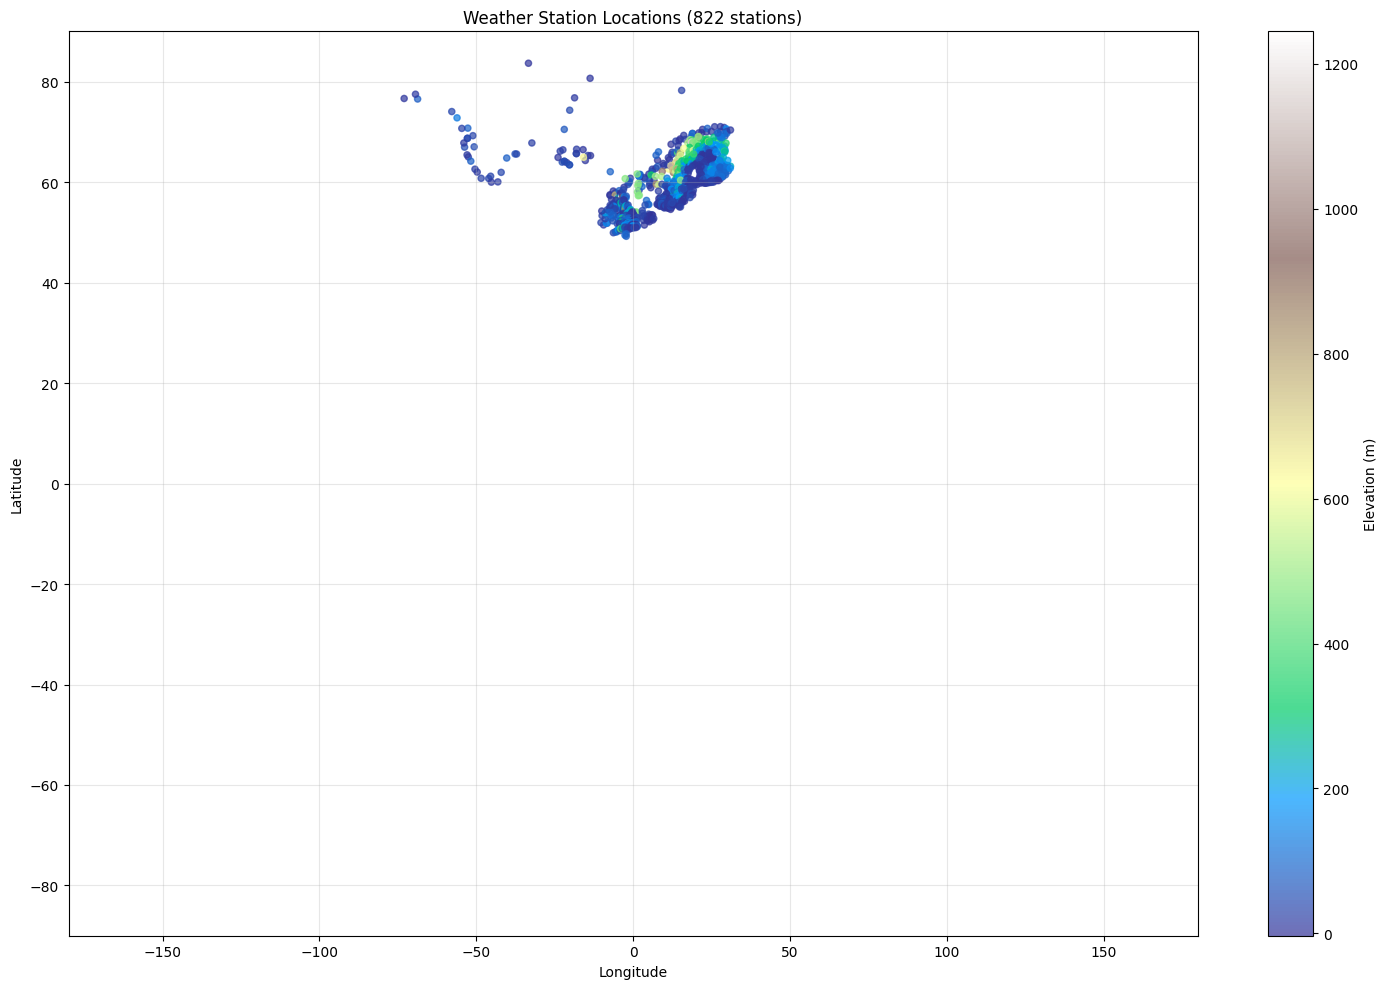

In [17]:
# Visualize station locations
fig, ax = plt.subplots(figsize=(15, 10))

scatter = ax.scatter(
    station_coords['longitude'], 
    station_coords['latitude'],
    c=station_coords['elevation'],
    cmap='terrain',
    s=20,
    alpha=0.7
)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Weather Station Locations ({n_stations} stations)')
plt.colorbar(scatter, label='Elevation (m)')

# Add simple coastlines approximation (optional, just grid lines for reference)
ax.grid(True, alpha=0.3)
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)

plt.tight_layout()
plt.show()

## 8. Create Train/Validation/Test Split

In [18]:
# Temporal split (not random - preserve time ordering)
# Train: Jan-Sep (75%), Validation: Oct-Nov (17%), Test: Dec (8%)

print("=" * 60)
print("Creating Temporal Train/Validation/Test Split")
print("=" * 60)

# Define split dates
train_end = '2022-09-30 23:59:59'
val_end = '2022-11-30 23:59:59'

df_filtered['split'] = 'train'
df_filtered.loc[df_filtered['timestamp'] > train_end, 'split'] = 'val'
df_filtered.loc[df_filtered['timestamp'] > val_end, 'split'] = 'test'

# Check split sizes
split_counts = df_filtered['split'].value_counts()
print(f"\nSplit sizes:")
for split in ['train', 'val', 'test']:
    count = split_counts.get(split, 0)
    pct = 100 * count / len(df_filtered)
    print(f"  {split}: {count:,} ({pct:.1f}%)")

# Date ranges per split
print(f"\nDate ranges:")
for split in ['train', 'val', 'test']:
    subset = df_filtered[df_filtered['split'] == split]
    print(f"  {split}: {subset['timestamp'].min()} to {subset['timestamp'].max()}")

Creating Temporal Train/Validation/Test Split

Split sizes:
  train: 7,104,704 (76.2%)
  val: 1,489,403 (16.0%)
  test: 732,842 (7.9%)

Date ranges:
  train: 2022-01-01 00:00:00 to 2022-09-30 23:59:00
  val: 2022-10-01 00:00:00 to 2022-11-30 23:59:00
  test: 2022-12-01 00:00:00 to 2022-12-31 23:59:00


## 9. Final Data Summary and Save

In [19]:
# Final data summary
print("=" * 60)
print("Final Preprocessed Data Summary")
print("=" * 60)

print(f"\nDataset shape: {df_filtered.shape}")
print(f"Number of stations: {df_filtered['station_id'].nunique()}")
print(f"Date range: {df_filtered['timestamp'].min()} to {df_filtered['timestamp'].max()}")
print(f"\nColumns ({len(df_filtered.columns)}):")
print(list(df_filtered.columns))

# Missing data in final dataset
print(f"\nMissing data in target variables:")
for var in target_vars:
    missing = df_filtered[var].isnull().sum()
    pct = 100 * missing / len(df_filtered)
    print(f"  {var}: {missing:,} ({pct:.2f}%)")

Final Preprocessed Data Summary

Dataset shape: (9326949, 32)
Number of stations: 822
Date range: 2022-01-01 00:00:00 to 2022-12-31 23:59:00

Columns (32):
['station_id', 'timestamp', 'latitude', 'longitude', 'elevation', 'name', 'temperature_2m', 'dewpoint_2m', 'wind_direction_10m', 'wind_speed_10m', 'surface_pressure', 'relative_humidity_2m', 'hour', 'day_of_year', 'month', 'day_of_week', 'hour_sin', 'hour_cos', 'doy_sin', 'doy_cos', 'wind_u', 'wind_v', 'temp_dewpoint_spread', 'temperature_2m_normalized', 'dewpoint_2m_normalized', 'relative_humidity_2m_normalized', 'wind_speed_10m_normalized', 'surface_pressure_normalized', 'wind_u_normalized', 'wind_v_normalized', 'temp_dewpoint_spread_normalized', 'split']

Missing data in target variables:
  temperature_2m: 216,097 (2.32%)
  dewpoint_2m: 299,305 (3.21%)
  relative_humidity_2m: 294,589 (3.16%)
  wind_speed_10m: 602,245 (6.46%)
  wind_direction_10m: 1,023,923 (10.98%)
  surface_pressure: 5,247,884 (56.27%)


In [20]:
# Save preprocessed data
print("\n" + "=" * 60)
print("Saving Preprocessed Data")
print("=" * 60)

# 1. Save main dataset
output_file = PROCESSED_DATA_DIR / "noaa_isd_preprocessed.parquet"
df_filtered.to_parquet(output_file, index=False)
print(f"✓ Saved preprocessed data: {output_file}")
print(f"  File size: {output_file.stat().st_size / 1e6:.1f} MB")

# 2. Save filtered station metadata
station_output = PROCESSED_DATA_DIR / "station_metadata.csv"
station_meta_filtered.to_csv(station_output, index=False)
print(f"✓ Saved station metadata: {station_output}")

# 3. Save distance matrix
distance_output = PROCESSED_DATA_DIR / "station_distance_matrix.npy"
np.save(distance_output, distance_matrix)
print(f"✓ Saved distance matrix: {distance_output}")

# 4. Save station ID mapping (for distance matrix indexing)
station_ids = station_coords.index.tolist()
station_id_mapping = {sid: idx for idx, sid in enumerate(station_ids)}

# 5. Save normalization stats and metadata
preprocessing_stats = {
    'normalization': normalization_stats,
    'station_id_to_idx': station_id_mapping,
    'n_stations': n_stations,
    'target_variables': target_vars,
    'features_normalized': FEATURES_TO_NORMALIZE,
    'valid_ranges': VALID_RANGES,
    'min_coverage_pct': MIN_COVERAGE_PCT,
    'split_dates': {
        'train_end': train_end,
        'val_end': val_end
    },
    'created_at': datetime.now().isoformat()
}

stats_output = PROCESSED_DATA_DIR / "preprocessing_stats.json"
with open(stats_output, 'w') as f:
    json.dump(preprocessing_stats, f, indent=2)
print(f"✓ Saved preprocessing stats: {stats_output}")

print("\n" + "=" * 60)
print("Preprocessing Complete!")
print("=" * 60)
print(f"\nNext steps:")
print("1. Create graph structure in notebook 05_graph_construction.ipynb")
print("2. Build baseline models in notebook 06_baseline_models.ipynb")
print("3. Implement GNN model in notebook 08_gnn_model.ipynb")


Saving Preprocessed Data
✓ Saved preprocessed data: C:\Users\Kata\Desktop\earth-sgnn\data\processed\noaa_isd_preprocessed.parquet
  File size: 215.5 MB
✓ Saved station metadata: C:\Users\Kata\Desktop\earth-sgnn\data\processed\station_metadata.csv
✓ Saved distance matrix: C:\Users\Kata\Desktop\earth-sgnn\data\processed\station_distance_matrix.npy
✓ Saved preprocessing stats: C:\Users\Kata\Desktop\earth-sgnn\data\processed\preprocessing_stats.json

Preprocessing Complete!

Next steps:
1. Create graph structure in notebook 05_graph_construction.ipynb
2. Build baseline models in notebook 06_baseline_models.ipynb
3. Implement GNN model in notebook 08_gnn_model.ipynb
